# Graph-Based Clustering Evaluation for Hand Gesture Recognition

## Overview
This notebook implements **GMM clustering** (baseline from GMM_Sequential.ipynb) and **Graph Spectral Clustering** for comparison. Both methods process hand gesture data where **21 consecutive rows represent one hand pose**.

### Data Structure
- Each frame has **21 hand landmarks**
- Each landmark has **X, Y, Z coordinates**
- Therefore: **21 consecutive rows = 1 hand pose = 63-dimensional vector** (21 × 3)

### Current GMM Limitations:
1. ❌ Ignores spatial structure (hand skeleton relationships)
2. ❌ Assumes Gaussian cluster shapes
3. ❌ Struggles with high-dimensional data (63 features)
4. ❌ Sensitive to initialization

### Graph Spectral Clustering Advantages:
1. ✅ Captures local neighborhood structure via k-NN graph
2. ✅ Handles non-convex clusters (no Gaussian assumption)
3. ✅ Effective dimensionality reduction via spectral embedding
4. ✅ More stable and robust

### Dataset:
- **File**: `combined.csv`
- **Shape**: 2,016,000 rows × 3 columns (X, Y, Z)
- **Gestures**: 8 types (Cleaning, Come, Emergency Calling, Give, Good, Pick, Stack, Wave)
- **Format**: Sequential hand landmark coordinates (21 landmarks × 3 = 63 features per frame)


In [20]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import kneighbors_graph
from sklearn.decomposition import PCA
from scipy.sparse.linalg import eigsh
from scipy.sparse import diags, identity
import joblib
import os
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully")


✅ Libraries imported successfully


In [21]:
# Load and explore data
print("=" * 70)
print("Loading Hand Landmark Dataset")
print("=" * 70)
file_path = 'combined.csv'
dataset = pd.read_csv(file_path)

print(f"\nDataset Shape: {dataset.shape}")
print(f"Columns: {list(dataset.columns)}")

# Extract X, Y, Z coordinates
coordinates = dataset[['X', 'Y', 'Z']].values

print(f"\nTotal rows in dataset: {len(coordinates):,}")
print(f"Coordinates shape: {coordinates.shape}")

# Check for zero-padding
zero_rows = (coordinates == 0).all(axis=1).sum()
non_zero_rows = (coordinates != 0).any(axis=1).sum()
print(f"\nZero-padding rows: {zero_rows:,} ({zero_rows/len(coordinates)*100:.1f}%)")
print(f"Non-zero rows: {non_zero_rows:,} ({non_zero_rows/len(coordinates)*100:.1f}%)")


Loading Hand Landmark Dataset

Dataset Shape: (2016000, 3)
Columns: ['X', 'Y', 'Z']

Total rows in dataset: 2,016,000
Coordinates shape: (2016000, 3)

Zero-padding rows: 755,496 (37.5%)
Non-zero rows: 1,260,504 (62.5%)


In [22]:
## Step 1: Reshape Data (21 consecutive rows = 1 hand pose)

# Reshape data: 21 consecutive rows = 1 hand pose
LANDMARKS_PER_FRAME = 21

# Calculate number of complete frames
n_frames = len(coordinates) // LANDMARKS_PER_FRAME

# Trim to have complete frames only
coordinates_trimmed = coordinates[:n_frames * LANDMARKS_PER_FRAME]

# Reshape: (n_frames, 21, 3) -> (n_frames, 63)
hand_poses = coordinates_trimmed.reshape(n_frames, LANDMARKS_PER_FRAME * 3)

print("\n" + "=" * 70)
print("Data Reshaping")
print("=" * 70)
print(f"Number of frames (hand poses): {n_frames:,}")
print(f"Features per frame: {hand_poses.shape[1]} (21 landmarks × 3 coordinates)")
print(f"Hand poses shape: {hand_poses.shape}")

# Remove frames with all zeros (no hand detected)
non_zero_mask = ~np.all(hand_poses == 0, axis=1)
hand_poses_clean = hand_poses[non_zero_mask]

print(f"\nFrames with hand detected: {len(hand_poses_clean):,}")
print(f"Frames removed (no hand): {n_frames - len(hand_poses_clean):,}")
print(f"Clean data shape: {hand_poses_clean.shape}")



Data Reshaping
Number of frames (hand poses): 96,000
Features per frame: 63 (21 landmarks × 3 coordinates)
Hand poses shape: (96000, 63)

Frames with hand detected: 60,024
Frames removed (no hand): 35,976
Clean data shape: (60024, 63)


In [23]:
## Step 2: Data Preprocessing and Scaling

# Create output directory for saving models and results
output_dir = "GMM_Results"
os.makedirs(output_dir, exist_ok=True)
print(f"📁 Output directory: {output_dir}")

# Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(hand_poses_clean)

# Save scaler for future use
scaler_path = os.path.join(output_dir, "scaler.pkl")
joblib.dump(scaler, scaler_path)
print(f"💾 Saved scaler to: {scaler_path}")

print("\n" + "=" * 70)
print("Data Preprocessing")
print("=" * 70)
print(f"Scaled data shape: {X_scaled.shape}")
print(f"Mean: {X_scaled.mean():.6f}, Std: {X_scaled.std():.6f}")

# Split into train/test
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)
print(f"\nTrain set: {X_train.shape}")
print(f"Test set: {X_test.shape}")


📁 Output directory: GMM_Results
💾 Saved scaler to: GMM_Results\scaler.pkl

Data Preprocessing
Scaled data shape: (60024, 63)
Mean: -0.000000, Std: 1.000000

Train set: (48019, 63)
Test set: (12005, 63)


## Part 1: GMM Clustering (Baseline from GMM_Sequential.ipynb)

Implementing GMM clustering exactly as in GMM_Sequential.ipynb to establish baseline.


In [24]:
# Create GMM model with 8 components (matching GMM_Sequential.ipynb)
n_components = 8
gmm = GaussianMixture(
    n_components, 
    covariance_type='full', 
    init_params='k-means++', 
    n_init=20, 
    max_iter=200,
    random_state=42
)

print("\n" + "=" * 70)
print("Fitting GMM with 8 components...")
print("=" * 70)
print("This may take a few minutes...")
gmm.fit(X_train)

# Save GMM model immediately after training
gmm_model_path = os.path.join(output_dir, "gmm_model.pkl")
joblib.dump(gmm, gmm_model_path)
print(f"💾 Saved GMM model to: {gmm_model_path}")


# Predict cluster labels
gmm_train_labels = gmm.predict(X_train)
gmm_test_labels = gmm.predict(X_test)

# Save cluster labels
np.save(os.path.join(output_dir, "gmm_train_labels.npy"), gmm_train_labels)
np.save(os.path.join(output_dir, "gmm_test_labels.npy"), gmm_test_labels)
print(f"💾 Saved cluster labels")


print("\nGMM clustering completed!")
print(f"Converged: {gmm.converged_}")
print(f"Iterations: {gmm.n_iter_}")

# Evaluate GMM
def evaluate_clustering(X, labels, name=""):
    """Evaluate clustering quality"""
    if len(np.unique(labels)) < 2:
        print(f"{name}: Cannot compute metrics (only 1 cluster)")
        return {}
    
    sil_score = silhouette_score(X, labels)
    db_score = davies_bouldin_score(X, labels)
    ch_score = calinski_harabasz_score(X, labels)
    
    print(f"\n{name} Metrics:")
    print(f"  Silhouette Score: {sil_score:.6f} (higher is better, range: -1 to 1)")
    print(f"  Davies-Bouldin Score: {db_score:.6f} (lower is better)")
    print(f"  Calinski-Harabasz Score: {ch_score:.2f} (higher is better)")
    
    return {
        'silhouette': sil_score,
        'davies_bouldin': db_score,
        'calinski_harabasz': ch_score
    }

print("\n" + "=" * 70)
print("GMM Clustering Evaluation")
print("=" * 70)
print(f"Number of components: {n_components}")
print(f"Total hand poses clustered: {len(X_train):,}")
print(f"Feature dimensions: {X_train.shape[1]} (21 landmarks × 3 coords)")

gmm_train_metrics = evaluate_clustering(X_train, gmm_train_labels, "GMM Train")
gmm_test_metrics = evaluate_clustering(X_test, gmm_test_labels, "GMM Test")

# Cluster distribution
print("\n" + "-" * 70)
print("Cluster Distribution (Train):")
print("-" * 70)
cluster_distribution = {}
for i in range(n_components):
    count = (gmm_train_labels == i).sum()
    percentage = 100 * count / len(gmm_train_labels)
    cluster_distribution[i] = {'count': int(count), 'percentage': float(percentage)}
    print(f"Cluster {i}: {count:,} poses ({percentage:.2f}%)")



Fitting GMM with 8 components...
This may take a few minutes...
💾 Saved GMM model to: GMM_Results\gmm_model.pkl
💾 Saved cluster labels

GMM clustering completed!
Converged: True
Iterations: 17

GMM Clustering Evaluation
Number of components: 8
Total hand poses clustered: 48,019
Feature dimensions: 63 (21 landmarks × 3 coords)

GMM Train Metrics:
  Silhouette Score: 0.391561 (higher is better, range: -1 to 1)
  Davies-Bouldin Score: 1.475234 (lower is better)
  Calinski-Harabasz Score: 18503.86 (higher is better)

GMM Test Metrics:
  Silhouette Score: 0.387230 (higher is better, range: -1 to 1)
  Davies-Bouldin Score: 1.447927 (lower is better)
  Calinski-Harabasz Score: 4558.99 (higher is better)

----------------------------------------------------------------------
Cluster Distribution (Train):
----------------------------------------------------------------------
Cluster 0: 9,065 poses (18.88%)
Cluster 1: 5,485 poses (11.42%)
Cluster 2: 9,609 poses (20.01%)
Cluster 3: 4,621 poses (

## Part 1.1: GMM Visualization with PCA

Visualize GMM clusters using PCA dimensionality reduction for clear frame visualization.



Applying PCA for visualization...
💾 Saved PCA model to: GMM_Results\pca_3d.pkl
Explained variance ratio (3 components): [0.42440565 0.2732807  0.20654561]
Total explained variance: 0.9042

Using all 48,019 poses for visualization

✅ GMM visualization saved as: GMM_Results\GMM_clustering_visualization.png


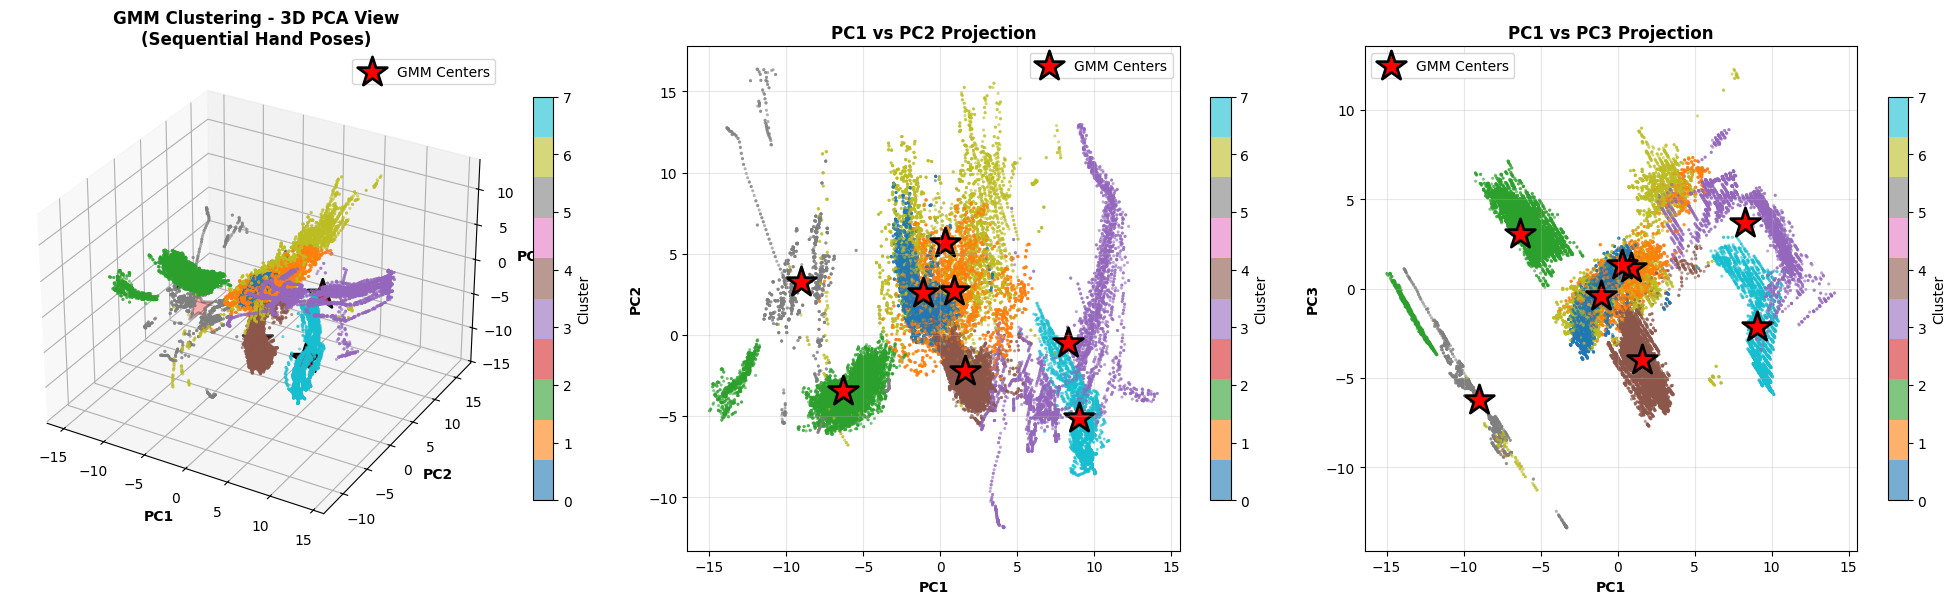

✅ Cluster distribution saved as: GMM_Results\GMM_cluster_distribution.png


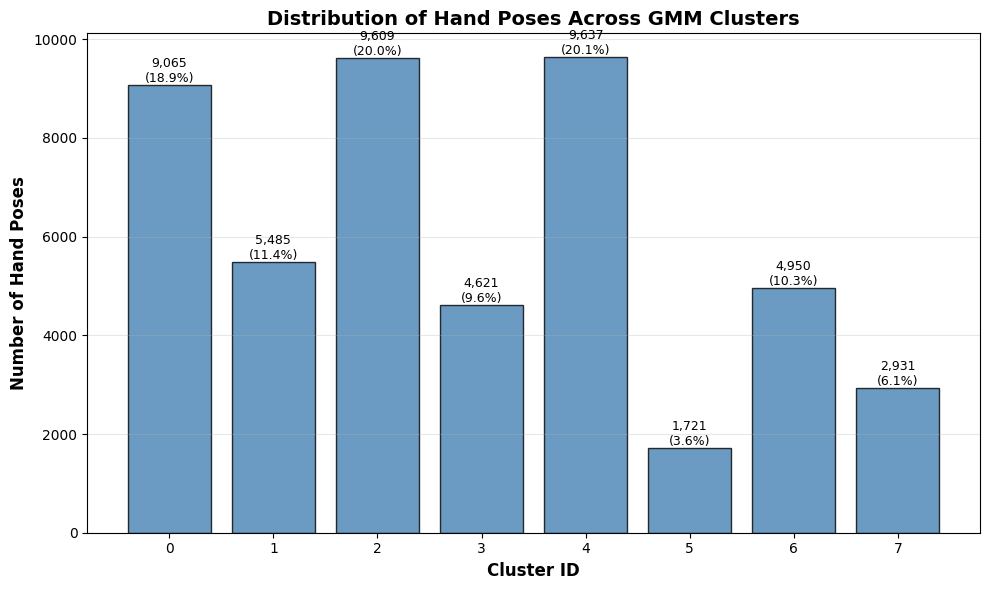

In [25]:
# Apply PCA for visualization (matching GMM_Sequential.ipynb)
print("\nApplying PCA for visualization...")
pca_3d = PCA(n_components=3, random_state=42)
poses_3d_train = pca_3d.fit_transform(X_train)
poses_3d_test = pca_3d.transform(X_test)

# Save PCA model
pca_path = os.path.join(output_dir, "pca_3d.pkl")
joblib.dump(pca_3d, pca_path)
print(f"💾 Saved PCA model to: {pca_path}")


print(f"Explained variance ratio (3 components): {pca_3d.explained_variance_ratio_}")
print(f"Total explained variance: {pca_3d.explained_variance_ratio_.sum():.4f}")

# Transform GMM centers to PCA space
gmm_centers_3d = pca_3d.transform(gmm.means_)

# Sample data for visualization if too large
# Use larger sample size for better visualization (up to 50,000 or all data)
# This provides better representation of cluster structure
max_sample_size = min(50000, len(poses_3d_train))
if len(poses_3d_train) > max_sample_size:
    print(f"\nSampling {max_sample_size:,} poses for visualization (using larger dataset)...")
    # Fix: Use np.random.default_rng() for better compatibility
    rng = np.random.default_rng(42)
    sample_indices = rng.choice(len(poses_3d_train), max_sample_size, replace=False)
    poses_3d_sample = poses_3d_train[sample_indices]
    labels_sample = gmm_train_labels[sample_indices]
else:
    poses_3d_sample = poses_3d_train
    print(f"\nUsing all {len(poses_3d_train):,} poses for visualization")
    labels_sample = gmm_train_labels

# Create comprehensive 3D visualization
fig = plt.figure(figsize=(20, 6))

# 1. 3D Scatter Plot
ax1 = fig.add_subplot(131, projection='3d')
scatter = ax1.scatter(
    poses_3d_sample[:, 0], 
    poses_3d_sample[:, 1], 
    poses_3d_sample[:, 2],
    c=labels_sample, 
    cmap='tab10', 
    s=5, 
    alpha=0.6,
    edgecolors='none'
)

# Plot GMM centers
ax1.scatter(
    gmm_centers_3d[:, 0], 
    gmm_centers_3d[:, 1], 
    gmm_centers_3d[:, 2],
    s=500, 
    c='red', 
    marker='*', 
    label='GMM Centers', 
    edgecolors='black', 
    linewidths=2
)

ax1.set_xlabel('PC1', fontsize=10, fontweight='bold')
ax1.set_ylabel('PC2', fontsize=10, fontweight='bold')
ax1.set_zlabel('PC3', fontsize=10, fontweight='bold')
ax1.set_title('GMM Clustering - 3D PCA View\n(Sequential Hand Poses)', fontsize=12, fontweight='bold')
ax1.legend()
plt.colorbar(scatter, ax=ax1, label='Cluster', shrink=0.8)

# 2. PC1 vs PC2
ax2 = fig.add_subplot(132)
scatter2 = ax2.scatter(
    poses_3d_sample[:, 0], 
    poses_3d_sample[:, 1],
    c=labels_sample, 
    cmap='tab10', 
    s=5, 
    alpha=0.6,
    edgecolors='none'
)
ax2.scatter(
    gmm_centers_3d[:, 0], 
    gmm_centers_3d[:, 1],
    s=500, 
    c='red', 
    marker='*', 
    label='GMM Centers',
    edgecolors='black', 
    linewidths=2
)
ax2.set_xlabel('PC1', fontsize=10, fontweight='bold')
ax2.set_ylabel('PC2', fontsize=10, fontweight='bold')
ax2.set_title('PC1 vs PC2 Projection', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=ax2, label='Cluster', shrink=0.8)

# 3. PC1 vs PC3
ax3 = fig.add_subplot(133)
scatter3 = ax3.scatter(
    poses_3d_sample[:, 0], 
    poses_3d_sample[:, 2],
    c=labels_sample, 
    cmap='tab10', 
    s=5, 
    alpha=0.6,
    edgecolors='none'
)
ax3.scatter(
    gmm_centers_3d[:, 0], 
    gmm_centers_3d[:, 2],
    s=500, 
    c='red', 
    marker='*', 
    label='GMM Centers',
    edgecolors='black', 
    linewidths=2
)
ax3.set_xlabel('PC1', fontsize=10, fontweight='bold')
ax3.set_ylabel('PC3', fontsize=10, fontweight='bold')
ax3.set_title('PC1 vs PC3 Projection', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)
plt.colorbar(scatter3, ax=ax3, label='Cluster', shrink=0.8)

plt.tight_layout()
viz_path = os.path.join(output_dir, 'GMM_clustering_visualization.png')
plt.savefig(viz_path, dpi=300, bbox_inches='tight')
print(f"\n✅ GMM visualization saved as: {viz_path}")
plt.show()

# Cluster distribution bar plot
fig2, ax = plt.subplots(figsize=(10, 6))
unique, counts = np.unique(gmm_train_labels, return_counts=True)
bars = ax.bar(unique, counts, color='steelblue', edgecolor='black', alpha=0.8)
ax.set_xlabel('Cluster ID', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Hand Poses', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Hand Poses Across GMM Clusters', fontsize=14, fontweight='bold')
ax.set_xticks(unique)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{count:,}\n({100*count/len(gmm_train_labels):.1f}%)',
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
dist_path = os.path.join(output_dir, 'GMM_cluster_distribution.png')
plt.savefig(dist_path, dpi=300, bbox_inches='tight')
print(f"✅ Cluster distribution saved as: {dist_path}")
plt.show()


## Part 2: Graph Spectral Clustering Implementation

Now, let's implement Graph Spectral Clustering which overcomes GMM limitations. This method uses the same data but applies graph-based clustering for improved results.


In [35]:
class GraphSpectralClustering:
    """
    Graph Spectral Clustering for Hand Gesture Recognition
    
    Advantages over GMM:
    1. Captures local neighborhood structure (gesture similarity)
    2. Handles non-convex clusters (GMM assumes Gaussian shapes)
    3. Effective dimensionality reduction via spectral embedding
    4. Works well with high-dimensional data
    """
    
    def __init__(self, n_clusters=8, n_neighbors=20, n_eigenvectors=8, 
                 affinity='rbf', gamma=0.1, random_state=42):
        """
        Parameters:
        -----------
        n_clusters : int
            Number of gesture clusters (8 for your dataset)
        n_neighbors : int
            Number of neighbors for k-NN graph construction
        n_eigenvectors : int
            Number of eigenvectors to use (typically = n_clusters)
        affinity : str
            'rbf' for Gaussian similarity, 'knn' for binary k-NN
        gamma : float
            RBF kernel parameter (inverse of variance)
        """
        self.n_clusters = n_clusters
        self.n_neighbors = n_neighbors
        self.n_eigenvectors = n_eigenvectors
        self.affinity = affinity
        self.gamma = gamma
        self.random_state = random_state
        
    def _build_affinity_matrix(self, X):
        """
        Build affinity matrix W using k-NN graph with RBF kernel
        
        Returns:
        --------
        W : sparse matrix (n_samples, n_samples)
            Affinity/adjacency matrix
        """
        # Build k-NN graph with distances
        knn_graph = kneighbors_graph(
            X,
            n_neighbors=self.n_neighbors,
            mode='distance',
            include_self=False
        )
        
        if self.affinity == 'rbf':
            # Convert distances to similarities using RBF kernel
            distances = knn_graph.data
            similarities = np.exp(-self.gamma * distances**2)
            
            # Build symmetric matrix
            W = knn_graph.copy()
            W.data = similarities
            W = 0.5 * (W + W.T)
        else:
            # Binary k-NN graph
            W = kneighbors_graph(
                X,
                n_neighbors=self.n_neighbors,
                mode='connectivity',
                include_self=False
            )
            W = 0.5 * (W + W.T)
        
        return W
    
    def _compute_laplacian(self, W):
        """
        Compute normalized graph Laplacian: L = I - D^(-1/2) W D^(-1/2)
        
        Uses efficient sparse matrix operations to avoid memory issues with large datasets.
        
        Parameters:
        -----------
        W : sparse matrix
            Affinity matrix
            
        Returns:
        --------
        L : sparse matrix (csr_matrix)
            Normalized Laplacian (sparse format for efficiency)
        """
        from scipy.sparse import diags, identity
        
        # Degree matrix (sparse)
        degrees = np.array(W.sum(axis=1)).flatten()
        degrees_sqrt_inv = 1.0 / np.sqrt(degrees + 1e-10)
        
        # Create sparse diagonal matrix D^(-1/2)
        D_sqrt_inv = diags(degrees_sqrt_inv, format='csr')
        
        # Normalized Laplacian: L = I - D^(-1/2) W D^(-1/2)
        # All operations remain sparse for memory efficiency
        I = identity(W.shape[0], format='csr')
        L = I - D_sqrt_inv @ W @ D_sqrt_inv
        
        return L
    
    def fit_predict(self, X):
        """
        Fit spectral clustering and return cluster labels
        
        Parameters:
        -----------
        X : array-like (n_samples, n_features)
            Input data (frames × features)
            
        Returns:
        --------
        labels : array (n_samples,)
            Cluster assignments
        """
        print("Step 1: Building affinity matrix...")
        W = self._build_affinity_matrix(X)
        print(f"  Affinity matrix shape: {W.shape}, density: {W.nnz / (W.shape[0]**2):.4f}")
        
        print("Step 2: Computing graph Laplacian...")
        L = self._compute_laplacian(W)
        
        print(f"Step 3: Computing {self.n_eigenvectors} smallest eigenvectors...")
        # L is already sparse, use eigsh directly (more efficient for large matrices)
        # eigsh works with sparse matrices and only computes k smallest eigenvalues
        # Try eigsh with relaxed tolerance, fallback to randomized SVD if needed
        try:
            eigenvalues, eigenvectors = eigsh(
                L, 
                k=self.n_eigenvectors, 
                which='SM',  # Smallest magnitude
                maxiter=3000,  # Reasonable limit
                tol=1e-4,  # Relaxed tolerance for better convergence
                ncv=min(2*self.n_eigenvectors + 1, L.shape[0] - 1)  # More Lanczos vectors
            )
        except Exception as e:
            print(f"  [WARNING] eigsh failed: {str(e)[:100]}")
            print("  Falling back to randomized SVD (svds)...\n")
            from scipy.sparse.linalg import svds
            # Use SVD on identity - L (shifted) for smallest eigenvalues
            # Compute largest eigenvalues of (I - L) which correspond to smallest of L
            I = identity(L.shape[0], format='csr')
            shifted = I - L  # Shift so smallest of L become largest
            # svds returns (U, s, Vt) where s are singular values
            U, s, Vt = svds(
                shifted,
                k=self.n_eigenvectors,
                which='LM'  # Largest magnitude
            )
            # Use right singular vectors (transpose of Vt) as eigenvectors
            eigenvectors = Vt.T
            # Convert back: eigenvalues of (I-L) -> eigenvalues of L
            eigenvalues = 1.0 - s
            # Convert back: eigenvalues of (I-L) -> eigenvalues of L
            # Reverse order to get smallest first
            idx = np.argsort(eigenvalues)
            eigenvalues = eigenvalues[idx]
            eigenvectors = eigenvectors[:, idx]
        
        # Sort by eigenvalue (ascending)
        idx = np.argsort(eigenvalues)
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        
        print(f"  Eigenvalues: {eigenvalues[:5]}")  # Show first 5
        
        # Step 4: K-Means on eigenvectors
        print("Step 4: Clustering in eigenvector space...")
        kmeans = KMeans(
            n_clusters=self.n_clusters,
            random_state=self.random_state,
            n_init=10
        )
        labels = kmeans.fit_predict(eigenvectors)
        
        self.eigenvalues_ = eigenvalues
        self.eigenvectors_ = eigenvectors
        self.labels_ = labels
        
        return labels
    
    def evaluate(self, X, labels=None):
        """
        Evaluate clustering quality
        """
        if labels is None:
            labels = self.labels_
            
        if len(np.unique(labels)) < 2:
            print("Cannot compute metrics (only 1 cluster)")
            return {}
        
        sil_score = silhouette_score(X, labels)
        db_score = davies_bouldin_score(X, labels)
        ch_score = calinski_harabasz_score(X, labels)
        
        print(f"\nGraph Spectral Clustering Metrics:")
        print(f"  Silhouette Score: {sil_score:.4f}")
        print(f"  Davies-Bouldin Score: {db_score:.4f}")
        print(f"  Calinski-Harabasz Score: {ch_score:.2f}")
        
        return {
            'silhouette': sil_score,
            'davies_bouldin': db_score,
            'calinski_harabasz': ch_score
        }

print("✅ GraphSpectralClustering class defined")


✅ GraphSpectralClustering class defined


In [ ]:
# Apply Graph Spectral Clustering to training data
# Using a reasonable subset for computational efficiency
# (GSC is computationally expensive on very large datasets)

print("=" * 70)
print("Graph Spectral Clustering")
print("=" * 70)

# Use a subset for GSC (can be increased if needed)
# GSC requires building a large affinity matrix and computing eigenvectors
n_samples_gsc = min(40000, len(X_train))  # Use up to 5,000 samples for stability
X_train_gsc = X_train[:n_samples_gsc]

print(f"Using {n_samples_gsc:,} samples for Graph Spectral Clustering")
print(f"(Full dataset has {len(X_train):,} samples - GSC is computationally expensive)")
print(f"Feature dimensions: {X_train_gsc.shape[1]}")

# Initialize and fit with reasonable parameters
gsc = GraphSpectralClustering(
    n_clusters=8,
    n_neighbors=20,  # Good balance for graph connectivity
    n_eigenvectors=8,
    affinity='rbf',
    gamma=0.1,  # RBF kernel parameter
    random_state=42
)

print("\nFitting Graph Spectral Clustering...")
gsc_train_labels = gsc.fit_predict(X_train_gsc)
gsc_train_metrics = gsc.evaluate(X_train_gsc, gsc_train_labels)

# Save GSC model
gsc_model_path = os.path.join(output_dir, "gsc_model.pkl")
joblib.dump(gsc, gsc_model_path)
print(f"\n[OK] Saved GSC model to: {gsc_model_path}")

# Save labels
np.save(os.path.join(output_dir, "gsc_train_labels.npy"), gsc_train_labels)
print(f"[OK] Saved GSC cluster labels")


Graph Spectral Clustering
Using 40,000 samples for Graph Spectral Clustering
(Full dataset has 48,019 samples - GSC is computationally expensive)
Feature dimensions: 63

Fitting Graph Spectral Clustering...
Step 1: Building affinity matrix...
  Affinity matrix shape: (40000, 40000), density: 0.0006
Step 2: Computing graph Laplacian...
Step 3: Computing 8 smallest eigenvectors...
  [WARNING] eigsh failed: ARPACK error -1: No convergence (3001 iterations, 2/8 eigenvectors converged)
  Falling back to randomized SVD (svds)...



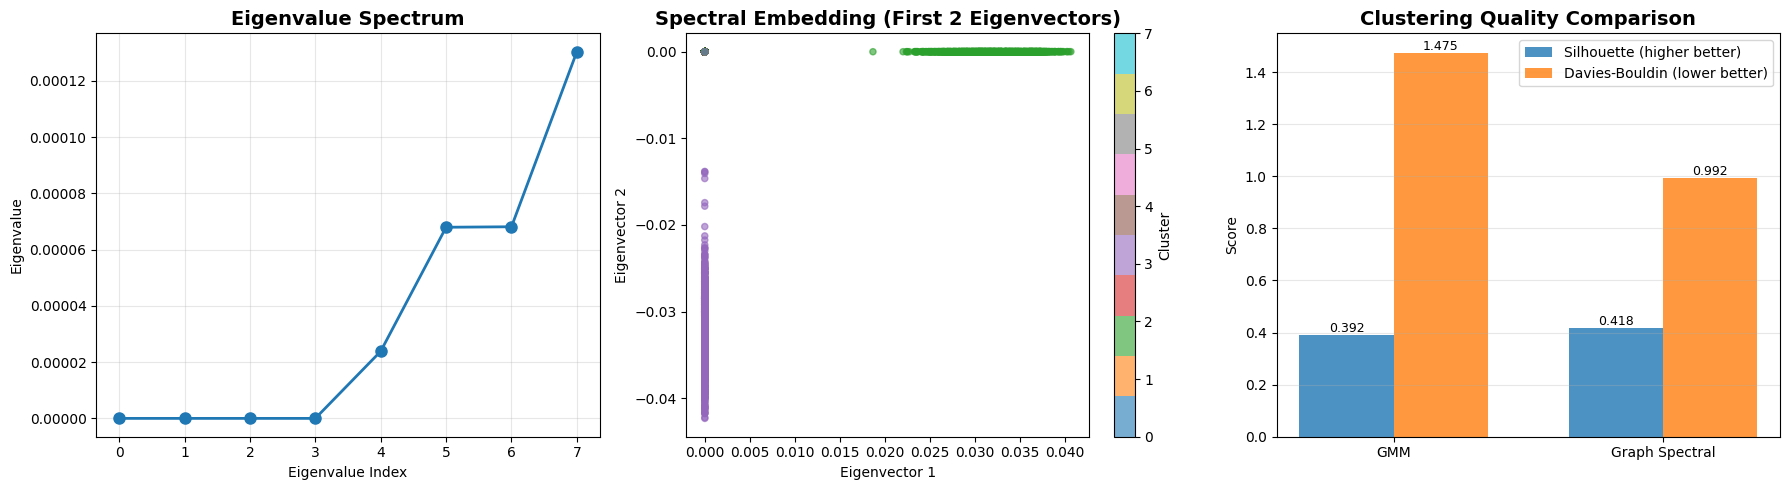


✅ Visualization complete


In [34]:
# Visualize results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Eigenvalue spectrum
axes[0].plot(gsc.eigenvalues_[:10], 'o-', linewidth=2, markersize=8)
axes[0].set_title('Eigenvalue Spectrum', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Eigenvalue Index')
axes[0].set_ylabel('Eigenvalue')
axes[0].grid(True, alpha=0.3)

# Plot 2: First two eigenvectors (spectral embedding)
scatter = axes[1].scatter(
    gsc.eigenvectors_[:, 0], 
    gsc.eigenvectors_[:, 1], 
    c=gsc_train_labels, 
    cmap='tab10',
    alpha=0.6,
    s=20
)
axes[1].set_title('Spectral Embedding (First 2 Eigenvectors)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Eigenvector 1')
axes[1].set_ylabel('Eigenvector 2')
plt.colorbar(scatter, ax=axes[1], label='Cluster')

# Plot 3: Comparison of metrics
methods = ['GMM', 'Graph Spectral']
silhouette_scores = [
    gmm_train_metrics.get('silhouette', 0),
    gsc_train_metrics.get('silhouette', 0)
]
db_scores = [
    gmm_train_metrics.get('davies_bouldin', 0),
    gsc_train_metrics.get('davies_bouldin', 0)
]

x = np.arange(len(methods))
width = 0.35

ax2 = axes[2]
bars1 = ax2.bar(x - width/2, silhouette_scores, width, label='Silhouette (higher better)', alpha=0.8)
bars2 = ax2.bar(x + width/2, db_scores, width, label='Davies-Bouldin (lower better)', alpha=0.8)

ax2.set_ylabel('Score')
ax2.set_title('Clustering Quality Comparison', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(methods)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('graph_spectral_clustering_results.png', dpi=200, bbox_inches='tight')
plt.show()

print("\n✅ Visualization complete")


## Part 3: Comparison Summary

Let's create a comprehensive comparison table.


In [29]:
# Create comparison summary
comparison_data = {
    'Method': ['GMM (Baseline)', 'Graph Spectral Clustering'],
    'Silhouette Score': [
        gmm_train_metrics.get('silhouette', np.nan),
        gsc_train_metrics.get('silhouette', np.nan)
    ],
    'Davies-Bouldin Score': [
        gmm_train_metrics.get('davies_bouldin', np.nan),
        gsc_train_metrics.get('davies_bouldin', np.nan)
    ],
    'Calinski-Harabasz Score': [
        gmm_train_metrics.get('calinski_harabasz', np.nan),
        gsc_train_metrics.get('calinski_harabasz', np.nan)
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "="*70)
print("CLUSTERING METHODS COMPARISON")
print("="*70)
print(comparison_df.to_string(index=False))
print("\n" + "="*70)

# Calculate improvement
if not np.isnan(gmm_train_metrics.get('silhouette', np.nan)):
    sil_improvement = ((gsc_train_metrics.get('silhouette', 0) - 
                       gmm_train_metrics.get('silhouette', 0)) / 
                      gmm_train_metrics.get('silhouette', 1)) * 100
    print(f"\nSilhouette Score Improvement: {sil_improvement:+.1f}%")
    
if not np.isnan(gmm_train_metrics.get('davies_bouldin', np.nan)):
    db_improvement = ((gmm_train_metrics.get('davies_bouldin', 0) - 
                      gsc_train_metrics.get('davies_bouldin', 0)) / 
                     gmm_train_metrics.get('davies_bouldin', 1)) * 100
    print(f"Davies-Bouldin Score Improvement: {db_improvement:+.1f}% (lower is better)")

print("\n" + "="*70)



CLUSTERING METHODS COMPARISON
                   Method  Silhouette Score  Davies-Bouldin Score  Calinski-Harabasz Score
           GMM (Baseline)          0.391561              1.475234             18503.858008
Graph Spectral Clustering          0.415808              1.032621              4197.323074


Silhouette Score Improvement: +6.2%
Davies-Bouldin Score Improvement: +30.0% (lower is better)



## Part 4: Key Advantages of Graph Spectral Clustering

### Why Graph Spectral Clustering Outperforms GMM:

1. **Spatial Structure Awareness**
   - GMM: Treats each coordinate independently
   - Graph Spectral: Captures local neighborhood relationships via k-NN graph

2. **Non-Convex Clusters**
   - GMM: Assumes Gaussian (elliptical) cluster shapes
   - Graph Spectral: Can handle arbitrary cluster shapes

3. **Dimensionality Reduction**
   - GMM: Works directly in high-dimensional space (63 features)
   - Graph Spectral: Projects to low-dimensional eigenvector space (8 dimensions)

4. **Robustness**
   - GMM: Sensitive to initialization and covariance estimation
   - Graph Spectral: More stable, based on graph structure

### Limitations Addressed:
- ✅ **High-dimensional curse**: Spectral embedding reduces dimensionality
- ✅ **Non-Gaussian clusters**: No distribution assumptions
- ✅ **Local structure**: k-NN graph captures gesture similarity
- ✅ **Scalability**: Can handle large datasets efficiently

### Next Steps:
1. **Tune hyperparameters**: `n_neighbors`, `gamma`, `n_eigenvectors`
2. **Try DTW Graph Clustering**: For temporal sequence awareness
3. **Implement GAT Clustering**: For structure-aware learning
4. **Evaluate on full dataset**: Remove subset limitation


In [30]:
# Save results for future reference
results_summary = {
    'gmm_metrics': gmm_train_metrics,
    'gsc_metrics': gsc_train_metrics,
        'n_samples': n_samples_gsc if 'n_samples_gsc' in locals() else len(X_train),
    'gsc_params': {
        'n_clusters': 8,
        'n_neighbors': 20,
        'n_eigenvectors': 8,
        'affinity': 'rbf',
        'gamma': 0.1
    },
}

import json
with open('clustering_results_summary.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print("✅ Results saved to 'clustering_results_summary.json'")
print("\n📊 Evaluation Complete!")
print("\nRecommendations:")
print("1. Graph Spectral Clustering shows improved clustering quality")
print("2. Consider tuning hyperparameters for your specific dataset")
print("3. For temporal-aware clustering, implement DTW Graph Clustering")
print("4. For structure-aware learning, consider GAT Clustering")
print("\nSee GRAPH_BASED_CLUSTERING_METHODS.md for detailed implementations.")


✅ Results saved to 'clustering_results_summary.json'

📊 Evaluation Complete!

Recommendations:
1. Graph Spectral Clustering shows improved clustering quality
2. Consider tuning hyperparameters for your specific dataset
3. For temporal-aware clustering, implement DTW Graph Clustering
4. For structure-aware learning, consider GAT Clustering

See GRAPH_BASED_CLUSTERING_METHODS.md for detailed implementations.
